In [1]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

2023-11-29 10:06:17.545032: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-29 10:06:22.444111: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-11-29 10:06:23.835110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 10:06:24.002930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [3]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [4]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [5]:
tf.keras.backend.clear_session()

In [6]:
subject = 'Pará - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [7]:
data = pd.read_csv('2003_mo_model_input_PA.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Pará - IDH Educacao,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - Consumo de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - IDH Renda,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.614461,8.348543,2.208327e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.618560,84.701,0.312867,0.748453,10387.404000,0.648977,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.614718,8.342554,2.222364e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.658098,80.221,0.312657,0.748776,10470.519385,0.649037,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.614976,8.336566,2.236400e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.906876,76.122,0.311736,0.749099,10546.359385,0.649097,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.615233,8.330578,2.250437e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.864305,76.544,0.310493,0.749421,10614.915813,0.649156,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.615490,8.324589,2.264474e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.179753,83.445,0.309128,0.749744,10682.772020,0.649216,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36200.254402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157.819932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36097.250375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36021.389035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


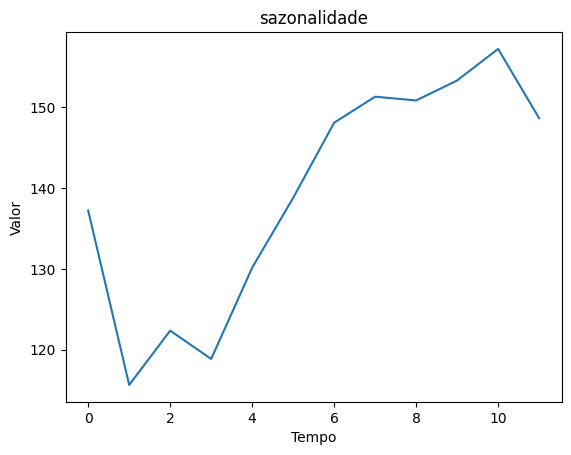

,sazonalidade
sazonalidade,
0,137.195563
1,115.654290
2,122.362058
3,118.862696
4,130.139895
5,138.766213
6,148.053851
7,151.268079
8,150.800639


In [8]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [9]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Pará - IDH Educacao,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará - IDH Longevidade,Pará- custo m2 (R$),Pará - IDH Renda,Pará - IDH,Pará - PIB - Estadual,Pará - PIB - Construção Civil,Pará - PIB - Per Capita,Pará - PIB - Preços de Mercado,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Pará - Consumo de Cimento (t)
0,2003-1,0.614461,8.348543,2.208327e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.618560,0.312867,0.748453,10387.404000,0.648977,0.669564,7.776091e+07,4.250430e+06,9.220374,6.851269e+07,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,137.195563,84.701
1,2003-2,0.614718,8.342554,2.222364e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.658098,0.312657,0.748776,10470.519385,0.649037,0.669764,7.787181e+07,4.255476e+06,9.225493,6.856365e+07,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,115.654290,80.221
2,2003-3,0.614976,8.336566,2.236400e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.906876,0.311736,0.749099,10546.359385,0.649097,0.669963,7.798271e+07,4.260521e+06,9.230612,6.861461e+07,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,122.362058,76.122
3,2003-4,0.615233,8.330578,2.250437e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49.864305,0.310493,0.749421,10614.915813,0.649156,0.670163,7.809361e+07,4.265566e+06,9.235731,6.866557e+07,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,118.862696,76.544
4,2003-5,0.615490,8.324589,2.264474e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.179753,0.309128,0.749744,10682.772020,0.649216,0.670362,7.820451e+07,4.270611e+06,9.240851,6.871652e+07,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,130.139895,83.445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36200.254402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.139895,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36157.819932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,138.766213,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36097.250375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,148.053851,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36021.389035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,151.268079,NaN


In [10]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
244        NaN
245        NaN
246        NaN
247        NaN
248        NaN
Name: Pará - Consumo de Cimento (t), Length: 249, dtype: float64

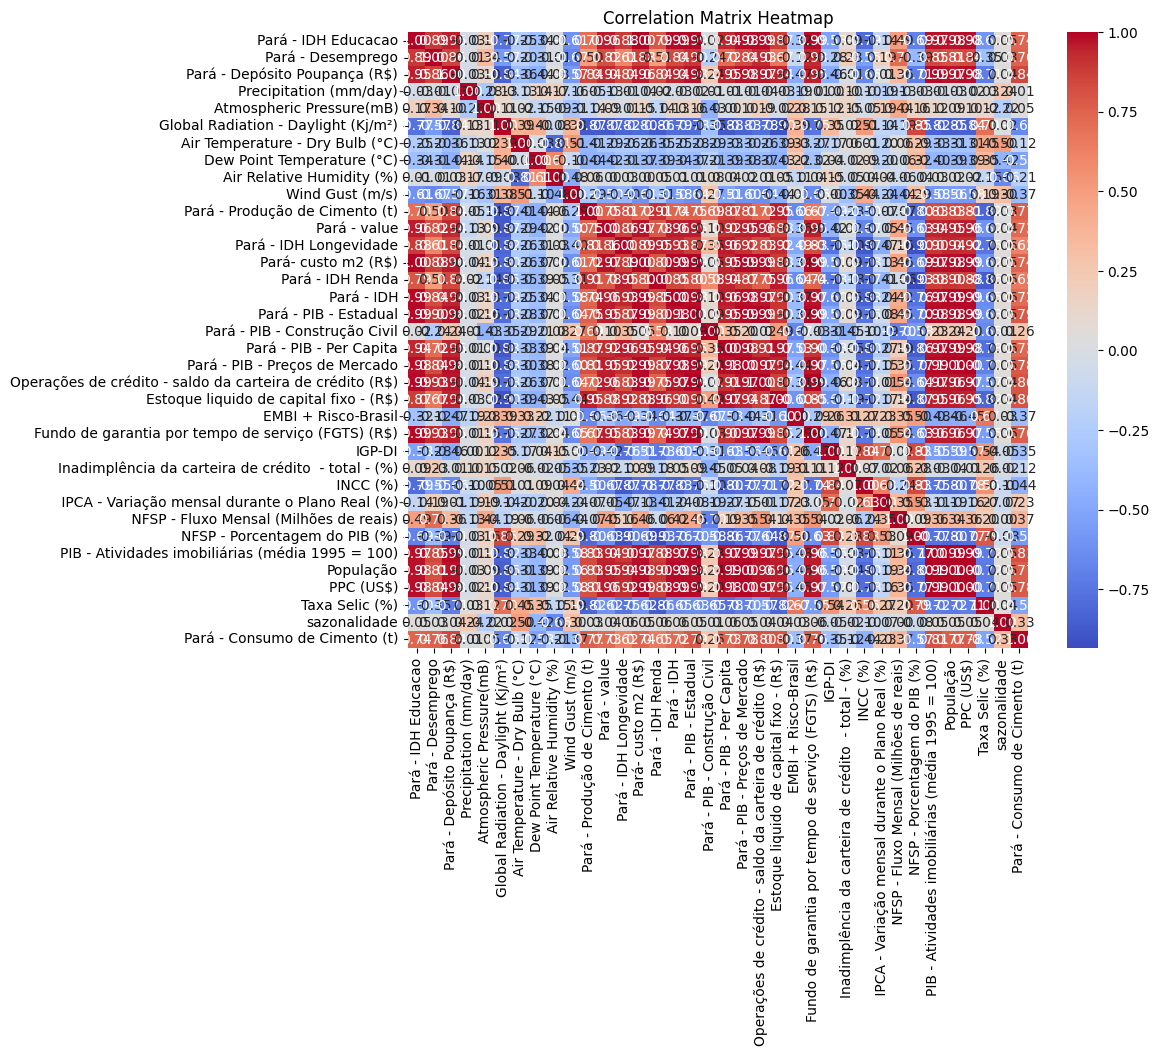

In [11]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [13]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Pará - IDH Educacao,2.305693e+09
1,Pará - Desemprego,3.761240e+05
2,Pará - Depósito Poupança (R$),3.564019e+05
3,Precipitation (mm/day),2.206599e+02
4,Atmospheric Pressure(mB),2.399922e+06
5,Global Radiation - Daylight (Kj/m²),1.180107e+02
6,Air Temperature - Dry Bulb (°C),3.036460e+06
7,Dew Point Temperature (°C),1.954741e+06
8,Air Relative Humidity (%),1.434116e+06
9,Wind Gust (m/s),3.737883e+02


In [14]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 9


,Pará - Desemprego,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,8.348543,2.208327e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.618560,0.312867,10387.404000,7.776091e+07,4.250430e+06,3.846831e+05,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,169.247665,1.611498,137.195563
1,8.342554,2.222364e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.658098,0.312657,10470.519385,7.787181e+07,4.255476e+06,3.852662e+05,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,170.176810,1.450389,115.654290
2,8.336566,2.236400e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.906876,0.311736,10546.359385,7.798271e+07,4.260521e+06,3.853051e+05,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,171.135713,1.870184,122.362058
3,8.330578,2.250437e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.864305,0.310493,10614.915813,7.809361e+07,4.265566e+06,3.857521e+05,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,172.116904,1.355287,118.862696
4,8.324589,2.264474e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.179753,0.309128,10682.772020,7.820451e+07,4.270611e+06,3.871640e+05,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,173.072271,1.585538,130.139895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,10.250979,5.791307e+06,3.390582,1009.043898,1121.157048,22.607433,76.772118,0.802919,91.733516,0.486125,24328.793298,9.691241e+07,4.320533e+06,3.068648e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,416.859692,0.583985,151.268079
176,10.243000,5.819657e+06,3.176669,1008.628410,1163.403062,22.595219,76.716789,0.805581,90.551229,0.486743,24419.778954,9.692692e+07,4.321567e+06,3.070265e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,417.748887,0.753312,150.800639
177,10.235022,5.848007e+06,3.405575,1008.302972,1146.914875,22.618844,77.725841,0.757239,89.566725,0.487330,24513.916366,9.694143e+07,4.322601e+06,3.078615e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,418.601189,0.882343,153.269548
178,10.227043,5.876356e+06,3.474336,1008.182759,1167.026539,22.650711,78.947908,0.725443,88.423018,0.487906,24605.100228,9.695594e+07,4.323635e+06,3.083099e+06,263.741041,1.073635e+07,0.491301,3.476080,0.370057,0.352728,-6243.191421,2.263185,198.211712,419.430070,1.004174,157.167998


In [15]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.551916,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.865796,-0.944487,-1.545100,-1.611324,-1.879590,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-0.155149
1,-1.541392,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.864286,-0.947419,-1.525719,-1.593606,-1.827144,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.709232
2,-1.530867,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.854783,-0.960256,-1.508034,-1.575887,-1.774697,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-1.225304
3,-1.520342,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.856409,-0.977583,-1.492048,-1.558169,-1.722251,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-1.477763
4,-1.509818,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.844360,-0.996604,-1.476224,-1.540451,-1.669804,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-0.664176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.134577,0.581185,0.268435,-0.608263,0.197993,0.097358,-0.262383,-0.257106,1.470276,1.705835,1.448487,-1.150848,1.351069,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.421090,-1.472938,0.860105
176,1.155834,0.333830,0.266783,-0.600695,0.195869,0.094614,-0.254250,-0.302267,1.478894,1.727051,1.450806,-1.140099,1.352673,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.432650,-0.879688,0.826382
177,1.177090,0.598521,0.265490,-0.603648,0.199978,0.144654,-0.401906,-0.339872,1.487076,1.749003,1.453124,-1.129349,1.360954,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.443731,-0.427616,1.004500
178,1.198347,0.678032,0.265012,-0.600046,0.205521,0.205258,-0.499020,-0.383559,1.495105,1.770266,1.455442,-1.118600,1.365401,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.454507,-0.000772,1.285752


In [16]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
0,-1.551916,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.865796,-0.944487,-1.545100,-1.611324,-1.879590,-1.310937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-1.798021,2.127040,-0.155149
1,-1.541392,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.864286,-0.947419,-1.525719,-1.593606,-1.827144,-1.310358,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.785942,1.562580,-1.709232
2,-1.530867,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.854783,-0.960256,-1.508034,-1.575887,-1.774697,-1.310320,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.773475,3.033368,-1.225304
3,-1.520342,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.856409,-0.977583,-1.492048,-1.558169,-1.722251,-1.309876,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.760719,1.229384,-1.477763
4,-1.509818,-3.339450,-3.741646,-0.809102,-3.734461,-3.709838,-2.714783,-1.844360,-0.996604,-1.476224,-1.540451,-1.669804,-1.308476,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.748299,2.036088,-0.664176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,0.940259,0.161651,0.269484,-0.590529,0.225854,0.104619,-0.139030,0.299109,1.387390,1.469657,1.377835,-1.196945,1.407354,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.261902,0.499090,0.860105
164,0.949364,-0.037587,0.267611,-0.595828,0.240034,0.134753,-0.196918,0.264159,1.390076,1.488498,1.388721,-1.202774,1.402136,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.276272,0.323875,0.826382
165,0.958468,0.124033,0.266028,-0.603766,0.263860,0.205986,-0.290180,0.223045,1.393115,1.510036,1.399606,-1.208604,1.398719,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.290351,0.198030,1.004500
166,0.967573,0.124172,0.265577,-0.616110,0.290165,0.308512,-0.490117,0.196722,1.399079,1.527887,1.410491,-1.214433,1.393142,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.304501,0.502803,1.285752


In [17]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      115.365
1       90.229
2       87.897
3       96.273
4       97.686
        ...   
163    133.744
164    128.527
165    147.510
166    138.511
167    103.294
Name: Pará - Consumo de Cimento (t), Length: 168, dtype: float64

In [18]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [19]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 25)

In [20]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Pará - Depósito Poupança (R$),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Pará - Produção de Cimento (t),Pará - value,Pará- custo m2 (R$),Pará - PIB - Estadual,Pará - PIB - Construção Civil,Operações de crédito - saldo da carteira de crédito (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),PPC (US$),Taxa Selic (%),sazonalidade
132,1.314904,0.414288,0.265926,-0.608116,0.258297,0.401264,-0.416316,0.853345,0.700824,0.748825,0.935321,0.389528,0.992500,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.878252,-0.590376,-0.155149
133,1.304272,0.346983,0.266261,-0.615577,0.286183,0.457138,-0.629874,0.827697,0.734205,0.771790,0.951749,0.327347,1.013803,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.887574,-0.476859,-1.709232
134,1.293639,0.395132,0.267536,-0.615146,0.298692,0.453982,-0.662354,0.817693,0.767990,0.794380,0.968178,0.265165,1.036490,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.896990,-0.089952,-1.225304
135,1.283006,0.256994,0.269546,-0.614237,0.293134,0.433162,-0.666384,0.807485,0.804399,0.816715,0.984606,0.202984,1.059637,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.906245,-0.814200,-1.477763
136,1.272374,-0.020156,0.270812,-0.609757,0.268722,0.377760,-0.639911,0.797174,0.840691,0.839945,1.001035,0.140803,1.080606,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.915208,-0.917944,-0.664176
137,1.261741,0.116353,0.271864,-0.600673,0.241672,0.312413,-0.567926,0.786599,0.877664,0.863741,1.017463,0.078622,1.101264,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.924126,-0.708692,-0.041835
138,1.251109,0.022379,0.271908,-0.592642,0.219368,0.250678,-0.543184,0.775874,0.914287,0.887991,1.033891,0.016441,1.123860,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.932114,-0.496126,0.628216
139,1.240476,-0.017975,0.270074,-0.585405,0.194718,0.165351,-0.424112,0.764971,0.951937,0.912457,1.050320,-0.045741,1.150086,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.939863,-0.251065,0.860105
140,1.229844,0.052236,0.268598,-0.582088,0.185114,0.116410,-0.299595,0.754149,0.987464,0.937292,1.066748,-0.107922,1.179474,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.947944,-0.593206,0.826382
141,1.219211,0.030292,0.267762,-0.586803,0.189227,0.123574,-0.311837,0.743512,1.017299,0.966339,1.083177,-0.170103,1.214576,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.956229,-0.100794,1.004500


In [21]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 25)

In [22]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells,
               third_layer_n_cells,
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=True,
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.LSTM(
        second_layer_n_cells,
        activation='tanh',
        return_sequences=(third_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    ))
        
    if third_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.1))
        model.add(tf.keras.layers.LSTM(
            third_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [23]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells, third_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(3)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells, third_layer_n_cells,
                                    want_verbose=0, seed=seed)
        
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(sorted(list_loss)[:2])

In [24]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    return df_results, predictions

In [25]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [36, 72, 144]
third_layer_cells_list = [0, 36, 72, 144]

In [26]:
def hyperparameter_tuning(train_input, train_target, 
                          first_layer_cells_list, second_layer_cells_list, third_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            for third_cells in third_layer_cells_list:
                if not third_cells > second_cells:
                    print(f"_________________________________________________________________________________________")
                    print(" ")
                    print(f" Testing [{first_cells}, {second_cells}, {third_cells}]")
                    print(f"_________________________________________________________________________________________")

                    winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                                first_cells, second_cells, third_cells)
                    print(" ")
                    print(f"first_layer_n_cells: {first_cells}")
                    print(f"second_layer_n_cells: {second_cells}")
                    print(f"third_layer_n_cells: {third_cells}")
                    if mean_loss < best_loss:
                        best_loss = mean_loss
                        best_combination = [first_cells, second_cells, third_cells, winner_seed]
                        print(f"best_loss: {best_loss}")
                        print(f"winner_seed: {winner_seed}")
                    print(" ")
            
    return best_combination

In [27]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list, 
                                         third_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
 Testing [36, 36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________


2023-11-29 10:06:26.952901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 10:06:26.953105: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-29 10:06:26.953297: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

val_loss: 538.078857421875
winner_seed: 2529644334


Step: 1 ___________________________________________
val_loss: 1703.6793212890625


Step: 2 ___________________________________________
val_loss: 1060.8328857421875
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 0
best_loss: 799.4558715820312
winner_seed: 2529644334
 
_________________________________________________________________________________________
 
 Testing [36, 36, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 278.4453430175781
winner_seed: 1066327757


Step: 1 ___________________________________________
val_loss: 71.83563232421875
winner_seed: 3962335981


Step: 2 ___________________________________________
val_loss: 57.3317985534668
winner_seed: 2617495979
 
first_layer_n_cells: 36
second_layer_n_cells: 36
third_layer_n_cells: 36
best_loss: 64.58371543884277
winner_seed: 2617495979
 
___

val_loss: 254.22677612304688


Step: 2 ___________________________________________
val_loss: 156.96499633789062
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 0
 
_________________________________________________________________________________________
 
 Testing [72, 144, 36]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 71.72727966308594
winner_seed: 2183955498


Step: 1 ___________________________________________
val_loss: 252.72579956054688


Step: 2 ___________________________________________
val_loss: 114.97303771972656
 
first_layer_n_cells: 72
second_layer_n_cells: 144
third_layer_n_cells: 36
 
_________________________________________________________________________________________
 
 Testing [72, 144, 72]
_________________________________________________________________________________________


Step: 0 _________________________________________

[72, 36, 36, 390927108]

In [28]:
best_combination

[72, 36, 36, 390927108]

In [29]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], best_combination[2],
                                    want_verbose=1, 
                                    seed=best_combination[3])

Epoch 1/10000
4/4 [==============================] - 3s 178ms/step - loss: 25658.9102 - val_loss: 13881.5859
Epoch 2/10000
4/4 [==============================] - 0s 13ms/step - loss: 24582.1836 - val_loss: 13127.4824
Epoch 3/10000
4/4 [==============================] - 0s 14ms/step - loss: 23833.0801 - val_loss: 12668.5312
Epoch 4/10000
4/4 [==============================] - 0s 15ms/step - loss: 23363.4512 - val_loss: 12409.8154
Epoch 5/10000
4/4 [==============================] - 0s 14ms/step - loss: 23050.8730 - val_loss: 12215.7148
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 22799.6504 - val_loss: 12039.5322
Epoch 7/10000
4/4 [==============================] - 0s 13ms/step - loss: 22562.7891 - val_loss: 11870.2432
Epoch 8/10000
4/4 [==============================] - 0s 13ms/step - loss: 22330.8848 - val_loss: 11702.8818
Epoch 9/10000
4/4 [==============================] - 0s 13ms/step - loss: 22102.5312 - val_loss: 11536.3555
Epoch 10/10000
4/4 [=======

Epoch 77/10000
4/4 [==============================] - 0s 13ms/step - loss: 10600.2041 - val_loss: 3819.1890
Epoch 78/10000
4/4 [==============================] - 0s 14ms/step - loss: 10484.6318 - val_loss: 3749.1548
Epoch 79/10000
4/4 [==============================] - 0s 13ms/step - loss: 10366.5928 - val_loss: 3680.2761
Epoch 80/10000
4/4 [==============================] - 0s 14ms/step - loss: 10249.5244 - val_loss: 3612.5728
Epoch 81/10000
4/4 [==============================] - 0s 14ms/step - loss: 10136.6904 - val_loss: 3545.3687
Epoch 82/10000
4/4 [==============================] - 0s 14ms/step - loss: 10022.0830 - val_loss: 3479.3777
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 9910.0859 - val_loss: 3414.3230
Epoch 84/10000
4/4 [==============================] - 0s 14ms/step - loss: 9798.6699 - val_loss: 3350.2546
Epoch 85/10000
4/4 [==============================] - 0s 14ms/step - loss: 9688.2070 - val_loss: 3287.2271
Epoch 86/10000
4/4 [===========

4/4 [==============================] - 0s 13ms/step - loss: 4431.4722 - val_loss: 817.2557
Epoch 154/10000
4/4 [==============================] - 0s 13ms/step - loss: 4380.5396 - val_loss: 802.0183
Epoch 155/10000
4/4 [==============================] - 0s 13ms/step - loss: 4332.1855 - val_loss: 787.1102
Epoch 156/10000
4/4 [==============================] - 0s 13ms/step - loss: 4281.7881 - val_loss: 772.8542
Epoch 157/10000
4/4 [==============================] - 0s 15ms/step - loss: 4235.0723 - val_loss: 758.8599
Epoch 158/10000
4/4 [==============================] - 0s 12ms/step - loss: 4185.8481 - val_loss: 745.4839
Epoch 159/10000
4/4 [==============================] - 0s 13ms/step - loss: 4140.4961 - val_loss: 732.3435
Epoch 160/10000
4/4 [==============================] - 0s 14ms/step - loss: 4093.1782 - val_loss: 719.7593
Epoch 161/10000
4/4 [==============================] - 0s 12ms/step - loss: 4047.3591 - val_loss: 707.5999
Epoch 162/10000
4/4 [==============================] 

4/4 [==============================] - 0s 12ms/step - loss: 2052.2246 - val_loss: 608.5794
Epoch 230/10000
4/4 [==============================] - 0s 14ms/step - loss: 2035.0266 - val_loss: 614.1487
Epoch 231/10000
4/4 [==============================] - 0s 13ms/step - loss: 2019.6901 - val_loss: 619.9644
Epoch 232/10000
4/4 [==============================] - 0s 14ms/step - loss: 2003.7775 - val_loss: 625.9182
Epoch 233/10000
4/4 [==============================] - 0s 13ms/step - loss: 1987.6395 - val_loss: 631.9220
Epoch 234/10000
4/4 [==============================] - 0s 14ms/step - loss: 1972.8939 - val_loss: 638.1483
Epoch 235/10000
4/4 [==============================] - 0s 14ms/step - loss: 1956.9037 - val_loss: 644.3665
Epoch 236/10000
4/4 [==============================] - 0s 13ms/step - loss: 1942.3883 - val_loss: 650.7845
Epoch 237/10000
4/4 [==============================] - 0s 14ms/step - loss: 1927.4230 - val_loss: 657.2747
Epoch 238/10000
4/4 [==============================] 

4/4 [==============================] - 0s 13ms/step - loss: 1356.7549 - val_loss: 1204.3168
Epoch 306/10000
4/4 [==============================] - 0s 13ms/step - loss: 1352.9821 - val_loss: 1212.5681
Epoch 307/10000
4/4 [==============================] - 0s 14ms/step - loss: 1348.9589 - val_loss: 1220.6877
Epoch 308/10000
4/4 [==============================] - 0s 13ms/step - loss: 1344.9291 - val_loss: 1228.6238
Epoch 309/10000
4/4 [==============================] - 0s 14ms/step - loss: 1342.0049 - val_loss: 1237.1809
Epoch 310/10000
4/4 [==============================] - 0s 13ms/step - loss: 1337.6265 - val_loss: 1245.0476
Epoch 311/10000
4/4 [==============================] - 0s 13ms/step - loss: 1334.2533 - val_loss: 1253.1100
Epoch 312/10000
4/4 [==============================] - 0s 13ms/step - loss: 1330.9071 - val_loss: 1261.2295
Epoch 313/10000
4/4 [==============================] - 0s 15ms/step - loss: 1327.5516 - val_loss: 1269.2383
Epoch 314/10000
4/4 [=======================

4/4 [==============================] - 0s 13ms/step - loss: 1213.6581 - val_loss: 1700.9164
Epoch 382/10000
4/4 [==============================] - 0s 14ms/step - loss: 1213.0646 - val_loss: 1705.8289
Epoch 383/10000
4/4 [==============================] - 0s 13ms/step - loss: 1212.2739 - val_loss: 1710.1738
Epoch 384/10000
4/4 [==============================] - 0s 14ms/step - loss: 1211.8691 - val_loss: 1715.0515
Epoch 385/10000
4/4 [==============================] - 0s 13ms/step - loss: 1211.1127 - val_loss: 1719.3792
Epoch 386/10000
4/4 [==============================] - 0s 13ms/step - loss: 1210.8159 - val_loss: 1724.4349
Epoch 387/10000
4/4 [==============================] - 0s 13ms/step - loss: 1210.0800 - val_loss: 1728.8787
Epoch 388/10000
4/4 [==============================] - 0s 13ms/step - loss: 1209.6885 - val_loss: 1733.5271
Epoch 389/10000
4/4 [==============================] - 0s 13ms/step - loss: 1208.8610 - val_loss: 1736.9775
Epoch 390/10000
4/4 [=======================

4/4 [==============================] - 0s 13ms/step - loss: 639.8823 - val_loss: 542.1817
Epoch 458/10000
4/4 [==============================] - 0s 13ms/step - loss: 630.0359 - val_loss: 534.8269
Epoch 459/10000
4/4 [==============================] - 0s 14ms/step - loss: 623.1609 - val_loss: 529.6498
Epoch 460/10000
4/4 [==============================] - 0s 14ms/step - loss: 619.4685 - val_loss: 530.3944
Epoch 461/10000
4/4 [==============================] - 0s 13ms/step - loss: 610.5223 - val_loss: 531.4973
Epoch 462/10000
4/4 [==============================] - 0s 15ms/step - loss: 601.5978 - val_loss: 543.1203
Epoch 463/10000
4/4 [==============================] - 0s 14ms/step - loss: 617.1595 - val_loss: 550.8904
Epoch 464/10000
4/4 [==============================] - 0s 14ms/step - loss: 595.5687 - val_loss: 543.9388
Epoch 465/10000
4/4 [==============================] - 0s 14ms/step - loss: 592.3029 - val_loss: 549.8766
Epoch 466/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 12ms/step - loss: 299.8619 - val_loss: 330.0666
Epoch 535/10000
4/4 [==============================] - 0s 12ms/step - loss: 300.8090 - val_loss: 392.9354
Epoch 536/10000
4/4 [==============================] - 0s 12ms/step - loss: 307.0969 - val_loss: 360.5307
Epoch 537/10000
4/4 [==============================] - 0s 12ms/step - loss: 298.9900 - val_loss: 344.7000
Epoch 538/10000
4/4 [==============================] - 0s 12ms/step - loss: 301.0145 - val_loss: 301.3658
Epoch 539/10000
4/4 [==============================] - 0s 11ms/step - loss: 290.4044 - val_loss: 317.9534
Epoch 540/10000
4/4 [==============================] - 0s 11ms/step - loss: 283.6234 - val_loss: 259.0101
Epoch 541/10000
4/4 [==============================] - 0s 11ms/step - loss: 291.3314 - val_loss: 260.6320
Epoch 542/10000
4/4 [==============================] - 0s 10ms/step - loss: 281.8880 - val_loss: 314.9808
Epoch 543/10000
4/4 [==============================] - 0s 10ms

4/4 [==============================] - 0s 15ms/step - loss: 180.9596 - val_loss: 247.3258
Epoch 612/10000
4/4 [==============================] - 0s 14ms/step - loss: 177.2872 - val_loss: 268.9458
Epoch 613/10000
4/4 [==============================] - 0s 15ms/step - loss: 175.8623 - val_loss: 241.6137
Epoch 614/10000
4/4 [==============================] - 0s 14ms/step - loss: 177.5778 - val_loss: 225.6196
Epoch 615/10000
4/4 [==============================] - 0s 14ms/step - loss: 170.0062 - val_loss: 234.5550
Epoch 616/10000
4/4 [==============================] - 0s 14ms/step - loss: 170.7339 - val_loss: 231.7635
Epoch 617/10000
4/4 [==============================] - 0s 14ms/step - loss: 169.8275 - val_loss: 220.9543
Epoch 618/10000
4/4 [==============================] - 0s 15ms/step - loss: 172.7561 - val_loss: 216.9393
Epoch 619/10000
4/4 [==============================] - 0s 14ms/step - loss: 169.3641 - val_loss: 219.9229
Epoch 620/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 14ms/step - loss: 124.6707 - val_loss: 300.7476
Epoch 689/10000
4/4 [==============================] - 0s 15ms/step - loss: 115.5046 - val_loss: 285.4573
Epoch 690/10000
4/4 [==============================] - 0s 14ms/step - loss: 115.7985 - val_loss: 286.5505
Epoch 691/10000
4/4 [==============================] - 0s 15ms/step - loss: 123.2375 - val_loss: 332.2767
Epoch 692/10000
4/4 [==============================] - 0s 14ms/step - loss: 113.9795 - val_loss: 340.7930
Epoch 693/10000
4/4 [==============================] - 0s 14ms/step - loss: 121.2116 - val_loss: 284.8073
Epoch 694/10000
4/4 [==============================] - 0s 14ms/step - loss: 119.9469 - val_loss: 247.3052
Epoch 695/10000
4/4 [==============================] - 0s 15ms/step - loss: 113.4976 - val_loss: 241.2028
Epoch 696/10000
4/4 [==============================] - 0s 15ms/step - loss: 118.5487 - val_loss: 257.4042
Epoch 697/10000
4/4 [==============================] - 0s 14ms

Epoch 766/10000
4/4 [==============================] - 0s 14ms/step - loss: 88.8525 - val_loss: 233.4511
Epoch 767/10000
4/4 [==============================] - 0s 13ms/step - loss: 88.4882 - val_loss: 191.5679
Epoch 768/10000
4/4 [==============================] - 0s 13ms/step - loss: 86.9937 - val_loss: 206.1901
Epoch 769/10000
4/4 [==============================] - 0s 15ms/step - loss: 87.3654 - val_loss: 199.7996
Epoch 770/10000
4/4 [==============================] - 0s 15ms/step - loss: 82.4884 - val_loss: 137.0064
Epoch 771/10000
4/4 [==============================] - 0s 14ms/step - loss: 86.7360 - val_loss: 151.9931
Epoch 772/10000
4/4 [==============================] - 0s 14ms/step - loss: 83.0825 - val_loss: 157.5551
Epoch 773/10000
4/4 [==============================] - 0s 14ms/step - loss: 83.4954 - val_loss: 152.1549
Epoch 774/10000
4/4 [==============================] - 0s 14ms/step - loss: 83.8594 - val_loss: 144.7039
Epoch 775/10000
4/4 [==============================] - 

4/4 [==============================] - 0s 14ms/step - loss: 65.4361 - val_loss: 205.5990
Epoch 845/10000
4/4 [==============================] - 0s 15ms/step - loss: 67.5044 - val_loss: 182.4777
Epoch 846/10000
4/4 [==============================] - 0s 14ms/step - loss: 65.3799 - val_loss: 176.1770
Epoch 847/10000
4/4 [==============================] - 0s 15ms/step - loss: 67.8603 - val_loss: 166.5373
Epoch 848/10000
4/4 [==============================] - 0s 14ms/step - loss: 70.5237 - val_loss: 195.0448
Epoch 849/10000
4/4 [==============================] - 0s 14ms/step - loss: 69.2601 - val_loss: 220.4989
Epoch 850/10000
4/4 [==============================] - 0s 14ms/step - loss: 67.1113 - val_loss: 245.8456
Epoch 851/10000
4/4 [==============================] - 0s 14ms/step - loss: 66.1637 - val_loss: 221.4275
Epoch 852/10000
4/4 [==============================] - 0s 13ms/step - loss: 64.7465 - val_loss: 199.3643
Epoch 853/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 14ms/step - loss: 57.7038 - val_loss: 292.4406
Epoch 923/10000
4/4 [==============================] - 0s 14ms/step - loss: 56.3664 - val_loss: 247.5623
Epoch 924/10000
4/4 [==============================] - 0s 14ms/step - loss: 50.6797 - val_loss: 229.0284
Epoch 925/10000
4/4 [==============================] - 0s 14ms/step - loss: 53.5799 - val_loss: 282.8399
Epoch 926/10000
4/4 [==============================] - 0s 14ms/step - loss: 60.6051 - val_loss: 277.3515
Epoch 927/10000
4/4 [==============================] - 0s 14ms/step - loss: 54.9092 - val_loss: 268.2047
Epoch 928/10000
4/4 [==============================] - 0s 14ms/step - loss: 56.0628 - val_loss: 229.7785
Epoch 929/10000
4/4 [==============================] - 0s 14ms/step - loss: 58.7595 - val_loss: 201.5237
Epoch 930/10000
4/4 [==============================] - 0s 14ms/step - loss: 54.6553 - val_loss: 209.4598
Epoch 931/10000
4/4 [==============================] - 0s 13ms/step - l

4/4 [==============================] - 0s 13ms/step - loss: 42.2206 - val_loss: 216.5489
Epoch 1001/10000
4/4 [==============================] - 0s 13ms/step - loss: 48.1666 - val_loss: 216.4510
Epoch 1002/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.5235 - val_loss: 218.4764
Epoch 1003/10000
4/4 [==============================] - 0s 11ms/step - loss: 42.5886 - val_loss: 213.8268
Epoch 1004/10000
4/4 [==============================] - 0s 11ms/step - loss: 45.0547 - val_loss: 223.4648
Epoch 1005/10000
4/4 [==============================] - 0s 10ms/step - loss: 38.6601 - val_loss: 260.9973
Epoch 1006/10000
4/4 [==============================] - 0s 11ms/step - loss: 42.1363 - val_loss: 255.6441
Epoch 1007/10000
4/4 [==============================] - 0s 10ms/step - loss: 41.7103 - val_loss: 230.5833
Epoch 1008/10000
4/4 [==============================] - 0s 11ms/step - loss: 40.4803 - val_loss: 224.6605
Epoch 1009/10000
4/4 [==============================] - 0s 11ms

4/4 [==============================] - 0s 13ms/step - loss: 36.1306 - val_loss: 229.0222
Epoch 1078/10000
4/4 [==============================] - 0s 14ms/step - loss: 35.1925 - val_loss: 230.8851
Epoch 1079/10000
4/4 [==============================] - 0s 14ms/step - loss: 39.2840 - val_loss: 248.7260
Epoch 1080/10000
4/4 [==============================] - 0s 14ms/step - loss: 40.7288 - val_loss: 248.8394
Epoch 1081/10000
4/4 [==============================] - 0s 14ms/step - loss: 40.0198 - val_loss: 219.4551
Epoch 1082/10000
4/4 [==============================] - 0s 14ms/step - loss: 45.3224 - val_loss: 207.0029
Epoch 1083/10000
4/4 [==============================] - 0s 14ms/step - loss: 42.6365 - val_loss: 225.5167
Epoch 1084/10000
4/4 [==============================] - 0s 15ms/step - loss: 40.2078 - val_loss: 246.2116
Epoch 1085/10000
4/4 [==============================] - 0s 14ms/step - loss: 43.2552 - val_loss: 258.0507
Epoch 1086/10000
4/4 [==============================] - 0s 17ms

4/4 [==============================] - 0s 13ms/step - loss: 36.8188 - val_loss: 225.7509
Epoch 1155/10000
4/4 [==============================] - 0s 14ms/step - loss: 31.2432 - val_loss: 235.0450
Epoch 1156/10000
4/4 [==============================] - 0s 14ms/step - loss: 31.2436 - val_loss: 235.3609
Epoch 1157/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.7562 - val_loss: 239.1969
Epoch 1158/10000
4/4 [==============================] - 0s 14ms/step - loss: 30.5358 - val_loss: 228.1945
Epoch 1159/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.4170 - val_loss: 230.7370
Epoch 1160/10000
4/4 [==============================] - 0s 14ms/step - loss: 32.1605 - val_loss: 236.0551
Epoch 1161/10000
4/4 [==============================] - 0s 15ms/step - loss: 32.9125 - val_loss: 226.2336
Epoch 1162/10000
4/4 [==============================] - 0s 14ms/step - loss: 34.6741 - val_loss: 227.1690
Epoch 1163/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 33.1795 - val_loss: 92.9777
Epoch 1232/10000
4/4 [==============================] - 0s 15ms/step - loss: 36.0952 - val_loss: 121.2132
Epoch 1233/10000
4/4 [==============================] - 0s 15ms/step - loss: 33.2304 - val_loss: 97.2216
Epoch 1234/10000
4/4 [==============================] - 0s 14ms/step - loss: 35.0272 - val_loss: 61.1935
Epoch 1235/10000
4/4 [==============================] - 0s 13ms/step - loss: 39.0792 - val_loss: 60.9196
Epoch 1236/10000
4/4 [==============================] - 0s 14ms/step - loss: 36.9454 - val_loss: 64.6491
Epoch 1237/10000
4/4 [==============================] - 0s 13ms/step - loss: 30.8625 - val_loss: 79.7529
Epoch 1238/10000
4/4 [==============================] - 0s 14ms/step - loss: 35.3102 - val_loss: 102.6700
Epoch 1239/10000
4/4 [==============================] - 0s 13ms/step - loss: 32.6550 - val_loss: 63.8370
Epoch 1240/10000
4/4 [==============================] - 0s 15ms/step -

4/4 [==============================] - 0s 15ms/step - loss: 76.0870 - val_loss: 359.0486
Epoch 1309/10000
4/4 [==============================] - 0s 15ms/step - loss: 65.3504 - val_loss: 418.6812
Epoch 1310/10000
4/4 [==============================] - 0s 15ms/step - loss: 64.9588 - val_loss: 387.9585
Epoch 1311/10000
4/4 [==============================] - 0s 14ms/step - loss: 61.1365 - val_loss: 406.6882
Epoch 1312/10000
4/4 [==============================] - 0s 15ms/step - loss: 58.7672 - val_loss: 330.6057
Epoch 1313/10000
4/4 [==============================] - 0s 15ms/step - loss: 44.6451 - val_loss: 304.5797
Epoch 1314/10000
4/4 [==============================] - 0s 14ms/step - loss: 50.0295 - val_loss: 289.7979
Epoch 1315/10000
4/4 [==============================] - 0s 14ms/step - loss: 60.8083 - val_loss: 193.8002
Epoch 1316/10000
4/4 [==============================] - 0s 14ms/step - loss: 49.8063 - val_loss: 504.6986
Epoch 1317/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 13ms/step - loss: 34.0618 - val_loss: 142.9465
Epoch 1386/10000
4/4 [==============================] - 0s 15ms/step - loss: 38.5815 - val_loss: 177.3295
Epoch 1387/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.9724 - val_loss: 228.6035
Epoch 1388/10000
4/4 [==============================] - 0s 14ms/step - loss: 44.4378 - val_loss: 166.6760
Epoch 1389/10000
4/4 [==============================] - 0s 14ms/step - loss: 37.8060 - val_loss: 259.9134
Epoch 1390/10000
4/4 [==============================] - 0s 14ms/step - loss: 42.2369 - val_loss: 170.7523
Epoch 1391/10000
4/4 [==============================] - 0s 14ms/step - loss: 39.8139 - val_loss: 137.1671
Epoch 1392/10000
4/4 [==============================] - 0s 14ms/step - loss: 36.5224 - val_loss: 141.9839
Epoch 1393/10000
4/4 [==============================] - 0s 14ms/step - loss: 38.1755 - val_loss: 119.0851
Epoch 1394/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 14ms/step - loss: 30.4593 - val_loss: 209.6339
Epoch 1463/10000
4/4 [==============================] - 0s 14ms/step - loss: 28.5716 - val_loss: 166.8354
Epoch 1464/10000
4/4 [==============================] - 0s 14ms/step - loss: 28.6778 - val_loss: 132.8658
Epoch 1465/10000
4/4 [==============================] - 0s 15ms/step - loss: 30.8904 - val_loss: 120.1474
Epoch 1466/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.6001 - val_loss: 156.6175
Epoch 1467/10000
4/4 [==============================] - 0s 13ms/step - loss: 31.9346 - val_loss: 182.9699
Epoch 1468/10000
4/4 [==============================] - 0s 14ms/step - loss: 33.2403 - val_loss: 202.6763
Epoch 1469/10000
4/4 [==============================] - 0s 14ms/step - loss: 30.5620 - val_loss: 218.0171
Epoch 1470/10000
4/4 [==============================] - 0s 15ms/step - loss: 30.5444 - val_loss: 185.8973
Epoch 1471/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 27.5407 - val_loss: 191.8266
Epoch 1540/10000
4/4 [==============================] - 0s 15ms/step - loss: 31.0451 - val_loss: 217.7903
Epoch 1541/10000
4/4 [==============================] - 0s 14ms/step - loss: 28.4391 - val_loss: 215.7782
Epoch 1542/10000
4/4 [==============================] - 0s 14ms/step - loss: 27.4283 - val_loss: 182.8252
Epoch 1543/10000
4/4 [==============================] - 0s 16ms/step - loss: 28.1007 - val_loss: 177.1376
Epoch 1544/10000
4/4 [==============================] - 0s 15ms/step - loss: 29.8345 - val_loss: 250.6300
Epoch 1545/10000
4/4 [==============================] - 0s 15ms/step - loss: 29.9974 - val_loss: 365.2720
Epoch 1546/10000
4/4 [==============================] - 0s 15ms/step - loss: 28.6119 - val_loss: 379.5266
Epoch 1547/10000
4/4 [==============================] - 0s 14ms/step - loss: 28.3120 - val_loss: 207.0476
Epoch 1548/10000
4/4 [==============================] - 0s 13ms

4/4 [==============================] - 0s 14ms/step - loss: 25.5628 - val_loss: 235.7116
Epoch 1617/10000
4/4 [==============================] - 0s 15ms/step - loss: 24.9362 - val_loss: 195.7941
Epoch 1618/10000
4/4 [==============================] - 0s 15ms/step - loss: 27.8376 - val_loss: 268.9573
Epoch 1619/10000
4/4 [==============================] - 0s 14ms/step - loss: 26.7424 - val_loss: 310.3545
Epoch 1620/10000
4/4 [==============================] - 0s 13ms/step - loss: 23.5399 - val_loss: 255.4854
Epoch 1621/10000
4/4 [==============================] - 0s 12ms/step - loss: 24.7144 - val_loss: 304.7406
Epoch 1622/10000
4/4 [==============================] - 0s 14ms/step - loss: 29.0813 - val_loss: 344.0475
Epoch 1623/10000
4/4 [==============================] - 0s 15ms/step - loss: 26.2541 - val_loss: 234.5707
Epoch 1624/10000
4/4 [==============================] - 0s 14ms/step - loss: 23.8564 - val_loss: 256.8907
Epoch 1625/10000
4/4 [==============================] - 0s 14ms

4/4 [==============================] - 0s 15ms/step - loss: 24.5890 - val_loss: 310.6457
Epoch 1694/10000
4/4 [==============================] - 0s 15ms/step - loss: 27.6291 - val_loss: 262.2275
Epoch 1695/10000
4/4 [==============================] - 0s 15ms/step - loss: 24.3120 - val_loss: 332.8416
Epoch 1696/10000
4/4 [==============================] - 0s 15ms/step - loss: 27.4404 - val_loss: 263.2112
Epoch 1697/10000
4/4 [==============================] - 0s 14ms/step - loss: 28.2727 - val_loss: 249.9328
Epoch 1698/10000
4/4 [==============================] - 0s 13ms/step - loss: 22.5477 - val_loss: 315.4341
Epoch 1699/10000
4/4 [==============================] - 0s 13ms/step - loss: 24.2815 - val_loss: 292.8577
Epoch 1700/10000
4/4 [==============================] - 0s 14ms/step - loss: 21.0963 - val_loss: 326.7671
Epoch 1701/10000
4/4 [==============================] - 0s 13ms/step - loss: 20.5410 - val_loss: 361.8584
Epoch 1702/10000
4/4 [==============================] - 0s 14ms

In [30]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [31]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 21ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,86.851181,86.777557,86.978752,88.383713,107.049332,129.490356,130.669113,130.48114,129.422379,124.953964,124.599045,120.979942
Target,110.704,91.638,90.744,82.108,97.49,96.803,118.687,109.761,120.188,131.62,125.374,115.811
Error,23.852821,4.860443,3.765251,6.275711,9.559334,32.687355,11.982117,20.720139,9.234375,6.666031,0.774956,5.168945


In [32]:
display(mae)
display(mape)

11.295624

0.1075147